In [1]:
import os
os.chdir('..')

from workflows.skeletons import *
from utils import os_lib, visualize, converter

In [2]:
import matplotlib.pyplot as plt
import cv2
import json

def vis_image(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    plt.show()

def vis_iamges(images):
    fig, axs = plt.subplots(1,4, figsize=(32, 8))

    for image, ax in zip(images, axs):
        ax.set_axis_off()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

    plt.show()

def log(title, content):
    if isinstance(content, dict):
        content = json.dumps(content, indent=4, ensure_ascii=False)
    elif isinstance(content, list):
        _content = ''
        for c in content:
            _content += str(c) + '\n'
        content = _content

    print(
        f"{visualize.TextVisualize.highlight_str(title)}\n"
        f"==========\n"
        f"{content}\n"
        f"----------\n"
    )

In [3]:
# 初始化一个输入
obj = dict(
    fp='data_cache/background_generator/test.jpg',
    width=512,
    height=512
)

(580, 610, 3)


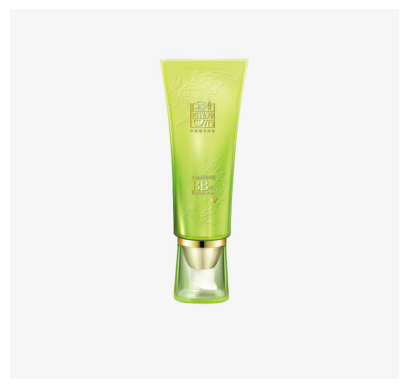

In [4]:
class LoadImageFromFile(Module):
    def on_process(self, obj, debug=False, **kwargs):
        fp = obj['fp']
        image = os_lib.loader.load_img(fp, channel_fixed_3=True)

        if debug:
            print(image.shape)
            vis_image(image)

        obj.update(image=image)
        return obj

load_image_from_file = LoadImageFromFile()
obj = load_image_from_file(obj, debug=True)

(512, 512, 3)


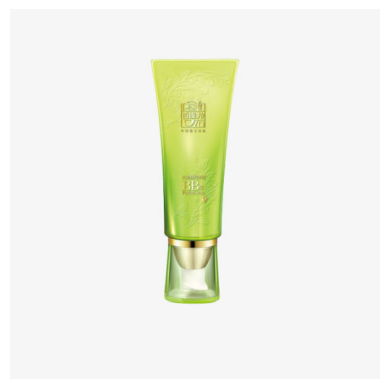

In [5]:
# 缩放并裁剪原图
from data_parse.cv_data_parse.data_augmentation import crop, scale, Apply

class ReszieCrop(Module):
    apply = Apply([
        scale.Proportion(choice_type=scale.MAX, interpolation=2),
        crop.Center()
    ])

    def on_process(self, obj, debug=False, **kwargs):
        image = obj['image']
        width = obj['width']
        height = obj['height']
        image = self.apply(image=image, dst=(width, height))['image']

        if debug:
            print(image.shape)
            vis_image(image)
        
        obj.update(image=image)
        return obj
    
reszie_crop = ReszieCrop()
obj = reszie_crop(obj, debug=True)

In [6]:
# 随机生成一些提示词
from templates.excluded.words import word_dict
import numpy as np

class MakePosPrompt(Module):
    def on_process(self, obj, debug=False, **kwargs):
        p = [
            *np.random.choice(list(word_dict['环境']['水'].values()), 2, replace=False),
            *np.random.choice(list(word_dict['环境']['天空'].values()), 2, replace=False),
            *np.random.choice(list(word_dict['画面']['画质'].values()), 4, replace=False),
            *np.random.choice(list(word_dict['画面']['艺术风格'].values()), 1, replace=False),
            *np.random.choice(list(word_dict['画面']['背景'].values()), 1, replace=False),
            *np.random.choice(list(word_dict['镜头']['镜头'].values()), 1, replace=False),
            *np.random.choice(list(word_dict['镜头']['其他构图'].values()), 1, replace=False),

        ]
        p = ', '.join(p)

        if debug:
            log('正面提示词', p)

        obj.update(prompt=p)
        return obj
    
make_pos_prompt = MakePosPrompt()
obj = make_pos_prompt(obj, debug=True)

正面提示词
beach, dripping, gradient_sky, night_sky, unreal engine rendered, checkered, absurdres, best quality, 80s movie, blurry_foreground, look up, multiple_views
----------



In [7]:
class MakeNegPrompt(Module):
    def on_process(self, obj, debug=False, **kwargs):
        p = np.random.choice(list(word_dict['反向提示词']['画面'].values()), 6, replace=False)
        p = ', '.join(p)

        if debug:
            log('负面提示词', p)

        obj.update(negative_prompt=p)
        return obj

make_neg_prompt = MakeNegPrompt()
obj = make_neg_prompt(obj, debug=True)

负面提示词
bad anatomy, logo, watermark, blurry, bad proportions, username
----------



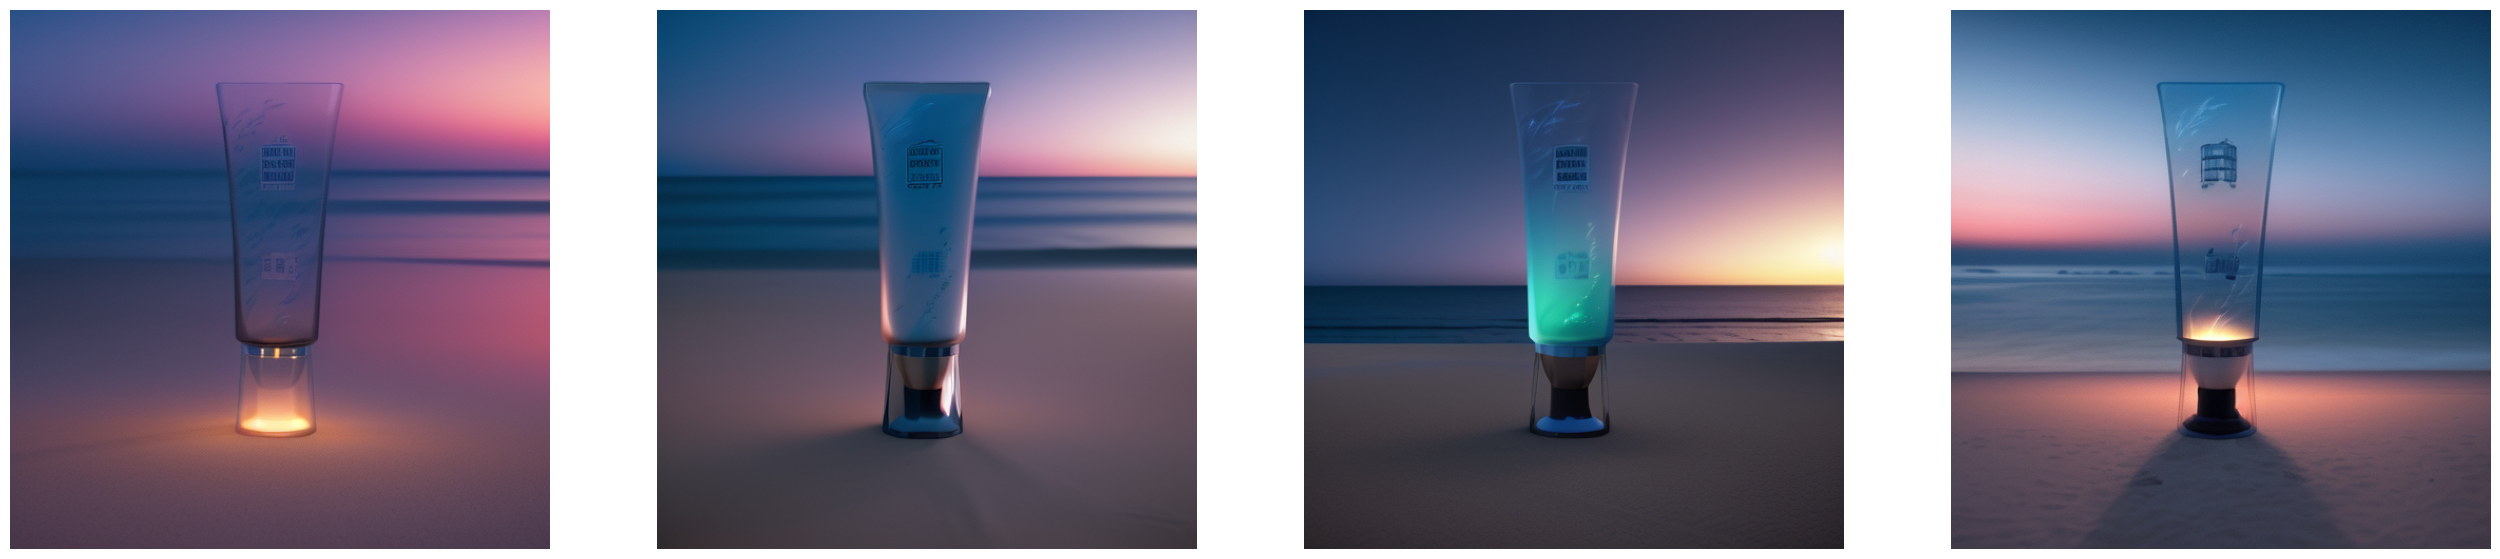

In [8]:
from models.stable_diffusion_webui import Model

class Txt2Img(Model):
    def on_process(self, obj, debug=False, **kwargs):
        controlnet_image = obj['image']
        batch_size = obj['batch_size']
        prompt = obj['prompt']
        negative_prompt = obj['negative_prompt']
        width = obj['width']
        height = obj['height']
    
        alwayson_scripts = {}
        controlnet_kwargs = {
            "args": [
                {
                    "enabled": True,
                    "module": "canny",
                    "model": 'control_v11p_sd15_canny_fp16',
                    "weight": 1.0,
                    "image": converter.DataConvert.image_to_base64(controlnet_image),
                    "resize_mode": "Crop and Resize",
                    "lowvram": False,
                    "processor_res": 512,
                    "threshold_a": 100,
                    "threshold_b": 200,
                    "guidance_start": 0.0,
                    "guidance_end": 0.9,
                    "control_mode": "Balanced",
                    "pixel_perfect": False
                }
            ]
        }
        alwayson_scripts.update(controlnet=controlnet_kwargs)
        
        post_kwargs = dict(
            prompt=prompt,
            negative_prompt=negative_prompt,
            width=width,
            height=height,
            steps=30,
            batch_size=batch_size,
            alwayson_scripts=alwayson_scripts,
        )

        images = self.txt2img(**post_kwargs)[:-1]

        if debug:
            vis_iamges(images)

        obj.update(images=images)
        return obj
    

# 先使用简单的文生图生成一个基础构图
txt2img = Txt2Img()
obj.update(batch_size=4)
obj = txt2img(obj, debug=True)

(512, 512)


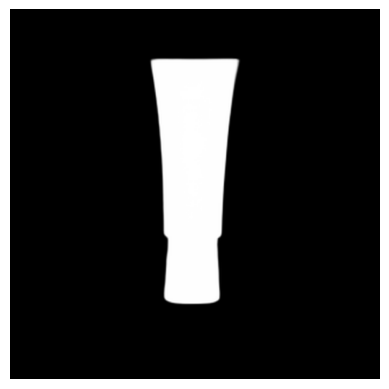

In [9]:
# 制作蒙版
class MakeMask(Model):
    """需要安装插件 stable-diffusion-webui-rembg
    请查看：https://github.com/AUTOMATIC1111/stable-diffusion-webui-rembg"""
    
    def on_process(self, obj, debug=False, **kwargs):
        image = obj['image']
        
        post_kwargs = dict(
            input_image=converter.DataConvert.image_to_base64(image),
            model='u2net',
            return_mask=True
        )

        ret = self._call('/rembg', **post_kwargs)

        image = converter.DataConvert.base64_to_image(ret['image'])

        if debug:
            print(image.shape)
            vis_image(image)

        obj.update(mask=image)

        return obj
        
make_mask = MakeMask()
obj = make_mask(obj, debug=True)

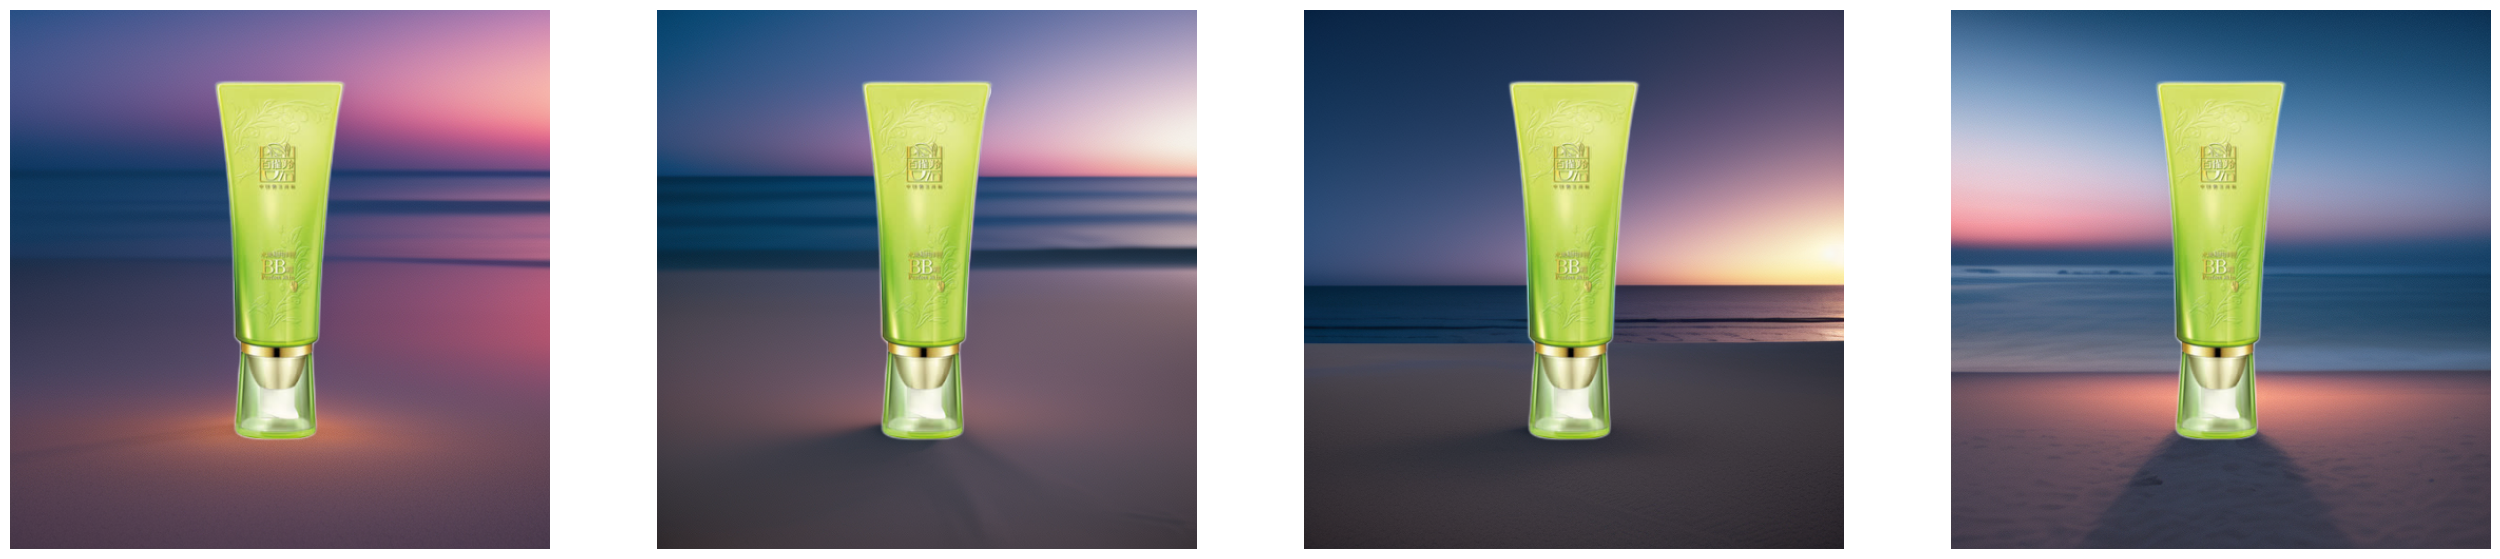

In [10]:
# 将原图覆盖回生成图
class CopyImage(Module):
    def on_process(self, obj, debug=False, **kwargs):
        images = obj['images']
        image = obj['image']
        mask = obj['mask']
        mask = mask / 255
        mask = mask[:, :, None]

        _images = []
        for img in images:
            img = image * mask + img * (1 - mask)
            img = np.clip(img, 0, 255)
            img = img.astype(np.uint8)
            _images.append(img)
        
        if debug:
            vis_iamges(_images)

        obj.update(images=_images)
        return obj
    
copy_image = CopyImage()
obj = copy_image(obj, debug=True)

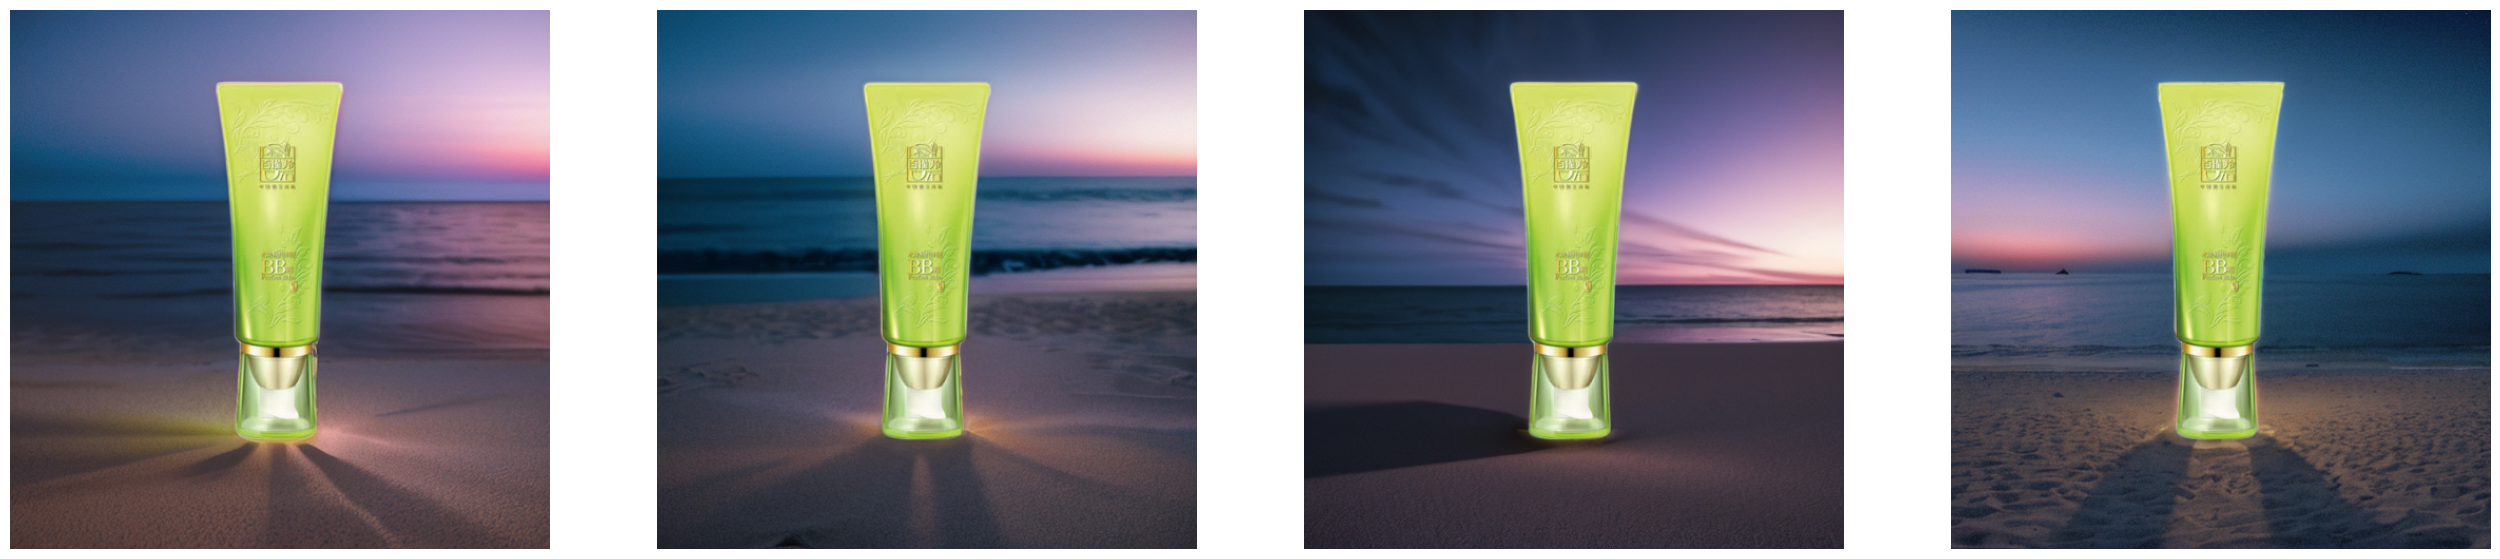

In [11]:
class Img2Img(Model):
    def on_process(self, obj, debug=False, **kwargs):
        prompt = obj['prompt']
        negative_prompt = obj['negative_prompt']
        width = obj['width']
        height = obj['height']

        images = obj['images']
        mask = obj['mask']
        mask = mask[:, :, None]

        alwayson_scripts = {}
        controlnet_kwargs = {
            "args": [
                {
                    "enabled": True,
                    "module": "canny",
                    "model": 'control_v11p_sd15_canny_fp16',
                    "weight": 1.0,
                    "resize_mode": "Crop and Resize",
                    "lowvram": False,
                    "processor_res": 512,
                    "threshold_a": 100,
                    "threshold_b": 200,
                    "guidance_start": 0.0,
                    "guidance_end": 0.9,
                    "control_mode": "Balanced",
                    "pixel_perfect": False
                }
            ]
        }
        alwayson_scripts.update(controlnet=controlnet_kwargs)

        _images = []
        for image in images:
            post_kwargs = {
                "batch_size": 1,
                "cfg_scale": 7,
                "n_iter": 1,
                "negative_prompt": negative_prompt,
                "prompt": prompt,
                "seed": -1,
                "steps": 20,
                "width": width,
                "height": height,
                "sampler_index": 'DPM++ 2M SDE',

                "init_images": [converter.DataConvert.image_to_base64(image)],
                'mask': converter.DataConvert.image_to_base64(mask),
                'inpainting_mask_invert': True,
                'mask_blur': 4,
                'inpainting_fill': 1,

                'inpaint_full_res': True,
                'inpaint_full_res_padding': 32,

                'denoising_strength': 0.75,
                'soft_inpainting_enabled': True,

                'mask_blend_power': 1,
                'mask_blend_scale': 0.5,
                'inpaint_detail_preservation': 7,
                'composite_mask_influence': 0.4,
                'composite_difference_threshold': 4,
                'composite_difference_contrast': 2,

                'alwayson_scripts': alwayson_scripts
            }

            _images += self.img2img(**post_kwargs)[:1]

        if debug:
            vis_iamges(_images)

        obj.update(images=_images)
        return obj

# 再做一次图生图，使商品图和背景图更加融合，且背景图更加精细
img2img = Img2Img()
obj = img2img(obj, debug=True)

In [12]:
# 简单演示，缓存到文件系统中
cacher = os_lib.FileCacher('data_cache/background_generator')

def cache(obj):
    images = obj['images']
    cacher.cache_batch(images, file_stems=list(range(len(images))))

cache(obj)

Save _id[data_cache/background_generator/0.jpg] successful!
Save _id[data_cache/background_generator/1.jpg] successful!
Save _id[data_cache/background_generator/2.jpg] successful!
Save _id[data_cache/background_generator/3.jpg] successful!


In [13]:
# 串成一条完整的流水线
pipeline = Pipeline(
    load_image_from_file,
    reszie_crop,
    make_pos_prompt,
    make_neg_prompt,
    txt2img,
    make_mask,
    copy_image,
    img2img,

    success_callbacks=[cache]
)